In [1]:
import numpy as np
from numpy.fft import rfft, rfftfreq
from scipy.sparse import spdiags
from scipy import signal
from scipy.ndimage import zoom
import scipy.io

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm

from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees,degrees2kilometers
from obspy.signal import filter as obspy_filter
import time
from scipy import interpolate
import obspy

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
proj=ccrs.PlateCarree()

import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

import time

import sys
sys.path.append('/home/yaolinm/Projects/Mexico2/')
sys.path.append('/home/yaolinm/Projects/Mexico/a1das-v2-main/')

from funcs.bp import *
from funcs.mccc import *
from funcs.utils import *
from a1das import core

from numba import njit
import numba
import copy
import glob,os,h5py
from obspy.core import UTCDateTime as UTC
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees

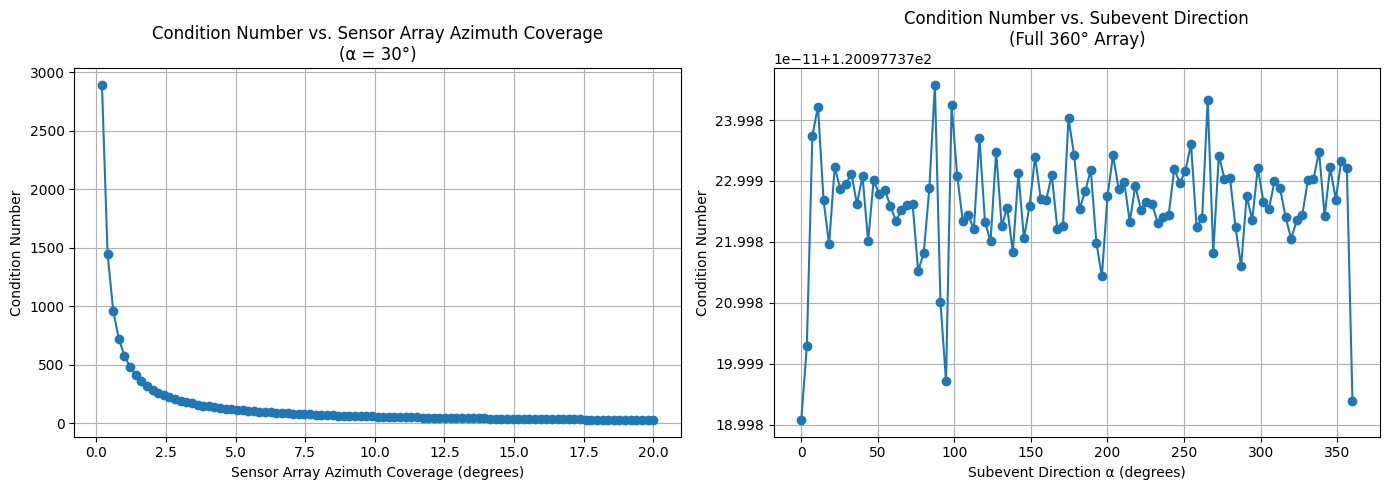

In [2]:
def compute_jacobian(sensor_angles, alpha, d, v, reference_index=0):
    """
    Computes the partial derivatives (Jacobian) of the travel time differences
    relative to the first channel (sensor at reference_index).
    
    For sensor i (relative to the reference sensor with azimuth θ₁):
      ∂(Δt_i)/∂d     = [cos(θ₁ - α) - cos(θ_i - α)] / v
      ∂(Δt_i)/∂α = (d/v)[sin(θ_i - α) - sin(θ₁ - α)]
      
    Parameters:
      sensor_angles : array_like
          Array of sensor azimuths (in radians).
      alpha : float
          Subevent direction (radians).
      d : float
          Subevent offset distance.
      v : float
          Propagation speed.
      reference_index : int, optional
          Index of the reference sensor (default is 0, i.e. first channel).
    
    Returns:
      dt_dd, dt_dalpha : ndarrays
          Partial derivatives for each sensor.
    """
    theta_ref = sensor_angles[reference_index]
    dt_dd = (np.cos(theta_ref - alpha) - np.cos(sensor_angles - alpha)) / v
    dt_dalpha = (d / v) * (np.sin(sensor_angles - alpha) - np.sin(theta_ref - alpha))
    return dt_dd, dt_dalpha

def compute_condition_number(sensor_angles, alpha, d, v, reference_index=0):
    """
    Computes the condition number of the Jacobian matrix for travel time differences
    relative to the first sensor.
    """
    dt_dd, dt_dalpha = compute_jacobian(sensor_angles, alpha, d, v, reference_index)
    # Exclude the reference sensor row (its derivatives are zero)
    mask = np.arange(len(sensor_angles)) != reference_index
    J = np.column_stack((dt_dd[mask], dt_dalpha[mask]))
    return np.linalg.cond(J)

# --- Define Parameters ---
D = 1000.0           # km (geometric parameter, not used explicitly in the linearized form)
d = 1.0             # km, subevent offset (assumed small relative to D)
v = 6.0             # km/s, propagation speed
num_sensors = 36    # number of sensors in the array

# For Plot 1: Vary sensor array azimuth coverage with fixed subevent direction α = 30°.
alpha_fixed = np.deg2rad(150)  # fixed subevent direction (30° in radians)
coverage_angles_deg = np.linspace(0, 20, 100)  # coverage from 10° up to 360°
cond_numbers_coverage = []

for cov_deg in coverage_angles_deg:
    # Generate sensor angles uniformly distributed in [0, cov]
    sensor_angles = np.linspace(0, np.deg2rad(cov_deg), num_sensors, endpoint=True)
    cond_num = compute_condition_number(sensor_angles, alpha_fixed, d, v, reference_index=0)
    cond_numbers_coverage.append(cond_num)

# For Plot 2: Vary subevent direction α for a full-circle sensor array.
alpha_values_deg = np.linspace(0, 360, 100)
cond_numbers_alpha = []
# Full circle sensor array (0° to 360°)
sensor_angles_full = np.linspace(0, 2*np.pi/360*5, num_sensors, endpoint=False)

for alpha_deg in alpha_values_deg:
    alpha_rad = np.deg2rad(alpha_deg)
    cond_num = compute_condition_number(sensor_angles_full, alpha_rad, d, v, reference_index=0)
    cond_numbers_alpha.append(cond_num)

# --- Plotting the Results ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Condition Number vs. Sensor Array Azimuth Coverage
ax1.plot(coverage_angles_deg, cond_numbers_coverage, marker='o')
ax1.set_xlabel('Sensor Array Azimuth Coverage (degrees)')
ax1.set_ylabel('Condition Number')
ax1.set_title('Condition Number vs. Sensor Array Azimuth Coverage\n(α = 30°)')
ax1.grid(True)

# Plot 2: Condition Number vs. Subevent Direction (α)
ax2.plot(alpha_values_deg, cond_numbers_alpha, marker='o')
ax2.set_xlabel('Subevent Direction α (degrees)')
ax2.set_ylabel('Condition Number')
ax2.set_title('Condition Number vs. Subevent Direction\n(Full 360° Array)')
ax2.grid(True)

plt.tight_layout()
plt.show()

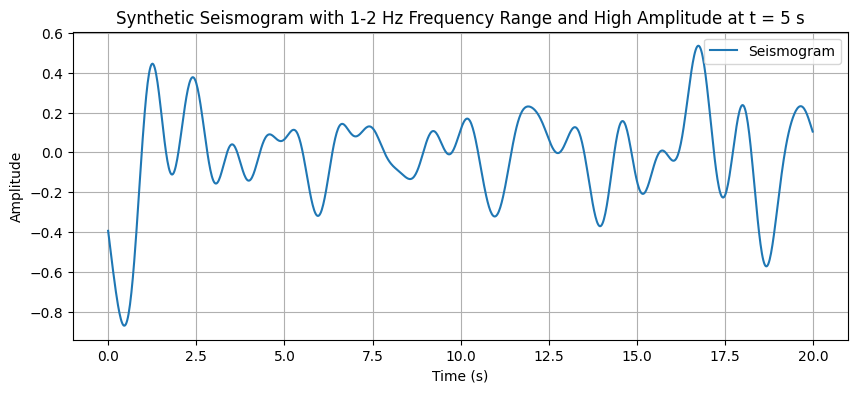

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Set parameters
fs = 50.0              # Sampling frequency (Hz)
duration = 20           # Total time (seconds)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Generate white noise as the base signal
noise = np.random.randn(len(t))

# Design a Butterworth bandpass filter for 1-2 Hz
lowcut = 0.2
highcut = 1
order = 4
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype='band')

# Filter the noise to get a band-limited signal
band_limited_signal = filtfilt(b, a, noise)

# Create an amplitude envelope: a baseline of 1 with a Gaussian bump at t = 5 s
envelope = np.ones_like(t)
# amp_factor = 10.0  # The additional peak amplitude factor
# sigma = 0.2        # Controls the width of the Gaussian bump (in seconds)
# gaussian_bump = amp_factor * np.exp(-((t - 5) ** 2) / (2 * sigma ** 2))
# envelope += gaussian_bump

# Apply the envelope to the band-limited signal
synthetic_seismogram = envelope * band_limited_signal

# Plot the synthetic seismogram
plt.figure(figsize=(10, 4))
plt.plot(t, synthetic_seismogram, label='Seismogram')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthetic Seismogram with 1-2 Hz Frequency Range and High Amplitude at t = 5 s')
plt.grid(True)
plt.legend()
plt.show()


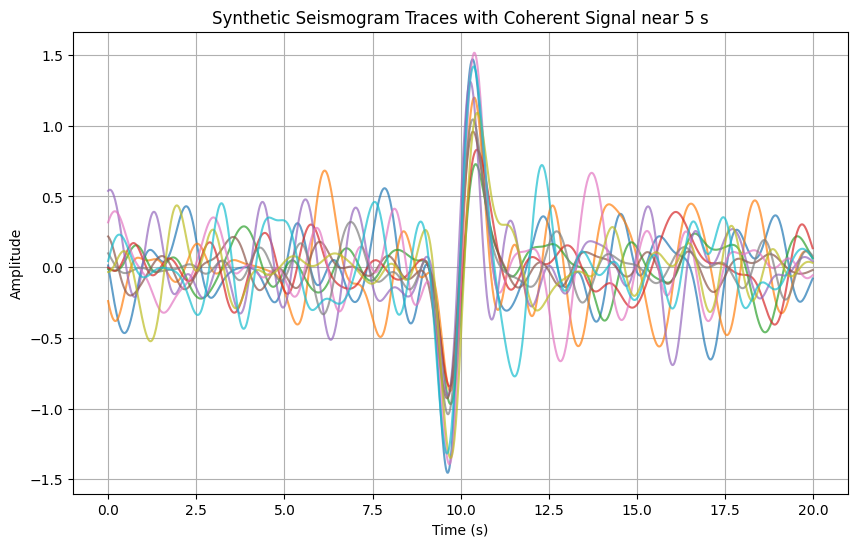

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Parameters
fs = 50.0                  # Sampling frequency (Hz)
total_duration = 30.0       # Total duration of the full trace in seconds
trim_start = 10.0            # Seconds to trim from the start (to remove initial artifacts)
n_traces = 100              # Number of traces to generate

# Create a time vector for the full trace
t_full = np.linspace(0, total_duration, int(fs * total_duration), endpoint=False)

# Design a Butterworth bandpass filter for the random component (0.2-1 Hz)
lowcut = 0.2
highcut = 1.0
order = 4
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype='band')

# Since we trim the first 5 s, placing the event at t0 = 10 s in the full trace makes it appear at 5 s.
t0 = 10.0                   # Center of the coherent event in the full trace
coherent_freq = 0.5         # Frequency of the coherent event (Hz) within the band
sigma_coherent = 0.5        # Controls the width of the coherent event (seconds)
coherent_event = np.sin(2 * np.pi * coherent_freq * (t_full -trim_start - t0)) * \
                 np.exp(-((t_full -trim_start - t0)**2) / (2 * sigma_coherent**2))
# Normalize the coherent event so its maximum amplitude is 1
coherent_event = coherent_event / np.max(np.abs(coherent_event))

synthetic_traces = []
np.random.seed(42)

# Loop to create each trace
for i in range(n_traces):
    # Generate white noise as the base random signal
    noise = np.random.randn(len(t_full))
    # Filter the noise to retain frequencies between 0.2 and 1 Hz
    random_component = filtfilt(b, a, noise)
    # Normalize the random component to keep it on a similar amplitude scale
    random_component = random_component / np.max(np.abs(random_component))
    
    # Combine the random component with the coherent event.
    # The coherent event is added with a weight factor (here, weight=1.0) so that it appears in phase across all traces.
    weight = 1.0  # Adjust this weight to set the relative amplitude of the coherent event.
    trace_full = random_component + weight * coherent_event
    
    # Trim the first 'trim_start' seconds to remove startup artifacts
    trim_index = int(trim_start * fs)
    trace_trim = trace_full[trim_index:]
    synthetic_traces.append(trace_trim)

# Convert the list of traces to a NumPy array (n_traces x n_samples_after_trim)
synthetic_traces = np.array(synthetic_traces)
# Create the trimmed time vector
t_trim = t_full[trim_index:] - trim_start

# Plot a subset (e.g., 10 traces) to verify that the coherent event is aligned (in phase) near 5 s in the trimmed traces
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(t_trim, synthetic_traces[i], label=f'Trace {i+1}', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthetic Seismogram Traces with Coherent Signal near 5 s')
plt.grid(True)
plt.show()


In [5]:
import numpy as np

def sensor_locations(azimuth_coverage_deg, num_sensors, epicenter_distance):

    coverage_rad = np.deg2rad(azimuth_coverage_deg)

    angles = np.linspace(-coverage_rad/2, coverage_rad/2, num_sensors)
    
    x_coords = epicenter_distance * np.cos(angles)
    y_coords = epicenter_distance * np.sin(angles)
    sensor_coords = np.column_stack((x_coords, y_coords))
    
    return sensor_coords

def cal_location(point1,point2):
    
    return np.sum((np.array(point1)-np.array(point2))**2)**0.5

In [6]:
def generate_synthetic_seismograms(azimuth_coverage_deg, n_traces, sensor_distance,
                                   source_location, velocity, fs, total_duration, trim_start,
                                   t0, coherent_freq, sigma_coherent,
                                   signal_frange, weight):

    sensor_coords = sensor_locations(azimuth_coverage_deg, num_sensors, sensor_distance)
    
    x_source, y_source = source_location
    travel_times = np.sqrt((sensor_coords[:, 0] - x_source)**2 + (sensor_coords[:, 1] - y_source)**2) / velocity
    
    shifts = (fs*(travel_times-sensor_distance/velocity)).astype('int')

    n_samples = int(fs * total_duration)
    t_full = np.linspace(0, total_duration, int(fs * total_duration), endpoint=False)

    lowcut = signal_frange[0]
    highcut = signal_frange[1]
    order = 4
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
     
    coherent_event = np.sin(2 * np.pi * coherent_freq * (t_full -trim_start - t0)) * \
                 np.exp(-((t_full -trim_start - t0)**2) / (2 * sigma_coherent**2))
    coherent_event = coherent_event / np.max(np.abs(coherent_event))

    synthetic_traces = []

    for i in range(n_traces):

        noise = np.random.randn(len(t_full))
        random_component = filtfilt(b, a, noise)
        random_component = random_component / np.max(np.abs(random_component))

        trace_full = random_component + weight * coherent_event

        trim_index = int(trim_start * fs)
        trace_trim = trace_full[trim_index:]
        trace_trim = np.roll(trace_trim, shifts[i])
        synthetic_traces.append(normalize(trace_trim))


    synthetic_traces = np.array(synthetic_traces)
    t_trim = t_full[trim_index:] - trim_start

    return sensor_coords, travel_times, t_trim, synthetic_traces

In [7]:
def compute_distances(grid_shape, point):

    x = np.arange(grid_shape[0])-grid_shape[0]/2
    y = np.arange(grid_shape[1])-grid_shape[1]/2
    xx, yy = np.meshgrid(x, y, indexing='ij')
    
    distances = np.hypot(xx - point[0], yy - point[1])
    return distances

In [398]:
### earthquake 1: freq=0.3Hz, freq_range=[0.1,0.5], rupture D= 30, magnitude = 7,amp=30, peak-finding window length=6s, 

npts_mat1=np.zeros((20,20))
master_mat1=np.zeros((20,20,50,50))

for d in range(20):
    print(d)
    for a in range(20):

        azimuth_coverage_deg = a+1   
        num_sensors = 10
        sensor_distance = 300+d*25        
        source_location = (-30/2**0.5, 30/2**0.5)     
        velocity = 4             
        fs = 50              
        duration = 40       
        trim_start=10
        t0=5
        freq=0.3
        freq_range=[0.1,0.5]
        width=0.5
        weight=30*(300/sensor_distance)**2

        sensor_coords, travel_times, t, seismograms = generate_synthetic_seismograms(
            azimuth_coverage_deg, num_sensors, sensor_distance,
            source_location, velocity, fs, duration, trim_start, t0, freq, width, freq_range, weight)

        shift_mats=[]
        for i in range(num_sensors):

            shift_mat=compute_distances((50,50),sensor_coords[i])/velocity*fs
            shift_mat-=shift_mat[25,25]
            shift_mat=shift_mat.astype('int')
            shift_mats.append(shift_mat)

        pwsed_bp=np.zeros((50,50,(duration-trim_start)*fs))
        for i in range(50):
            for j in range(50):
                todo=seismograms.copy()
                for k in range(num_sensors):
                    todo[k,:]=np.roll(todo[k,:],-shift_mats[k][i,j])
                pwsed_bp[i,j,:]=pws_stack(todo,axis=0)

        true_time=t0+width
        sumed=normalize(pwsed_bp)
        sumed[sumed==np.inf]=0
        master=np.max(sumed[:,:,:],axis=-1)
        npts=np.sum(master > 0.8*np.max(master))
        
        master_mat1[d,a,:,:]=master
        npts_mat1[d,a]=npts
        
np.save('data/das_bp_results/master_mat1_2.npy',master_mat1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [399]:
### earthquake 2: freq=1Hz, freq_range=[0.6,1.4], rupture D= 10, magnitude = 6, amp=10, peak-finding window length=2s

npts_mat2=np.zeros((20,20))
master_mat2=np.zeros((20,20,50,50))

for d in range(20):
    print(d)
    for a in range(20):

        azimuth_coverage_deg = a+1   
        num_sensors = 10
        sensor_distance = 300+d*25        
        source_location = (-10/2**0.5, 10/2**0.5)     
        velocity = 4             
        fs = 50              
        duration = 40       
        trim_start=10
        t0=5
        freq=1
        freq_range=[0.6,1.4]
        width=0.5
        weight=10*(300/sensor_distance)**2

        sensor_coords, travel_times, t, seismograms = generate_synthetic_seismograms(
            azimuth_coverage_deg, num_sensors, sensor_distance,
            source_location, velocity, fs, duration, trim_start, t0, freq, width, freq_range, weight)

        shift_mats=[]
        for i in range(num_sensors):

            shift_mat=compute_distances((50,50),sensor_coords[i])/velocity*fs
            shift_mat-=shift_mat[25,25]
            shift_mat=shift_mat.astype('int')
            shift_mats.append(shift_mat)

        pwsed_bp=np.zeros((50,50,(duration-trim_start)*fs))
        for i in range(50):
            for j in range(50):
                todo=seismograms.copy()
                for k in range(num_sensors):
                    todo[k,:]=np.roll(todo[k,:],-shift_mats[k][i,j])
                pwsed_bp[i,j,:]=pws_stack(todo,axis=0)

        true_time=t0+width
        sumed=normalize(pwsed_bp)
        sumed[sumed==np.inf]=0
        master=np.max(sumed[:,:,:],axis=-1)
        npts=np.sum(master > 0.8*np.max(master))

        master_mat2[d,a]=master
        npts_mat2[d,a]=npts
        
np.save('data/das_bp_results/master_mat2_2.npy',master_mat2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [400]:
### earthquake 3: freq=3Hz, freq_range=[1,5], rupture D= 3, magnitude = 5, amp=3, peak-finding window length=0.6s

npts_mat3=np.zeros((20,20))
master_mat3=np.zeros((20,20,50,50))

for d in range(20):
    print(d)
    for a in range(20):

        azimuth_coverage_deg = a+1   
        num_sensors = 10
        sensor_distance = 300+d*25        
        source_location = (-3/2**0.5, 3/2**0.5)     
        velocity = 4             
        fs = 50              
        duration = 40       
        trim_start=10
        t0=5
        freq=3
        freq_range=[1,5]
        width=0.5
        weight=3*(300/sensor_distance)**2

        sensor_coords, travel_times, t, seismograms = generate_synthetic_seismograms(
            azimuth_coverage_deg, num_sensors, sensor_distance,
            source_location, velocity, fs, duration, trim_start, t0, freq, width, freq_range, weight)

        shift_mats=[]
        for i in range(num_sensors):

            shift_mat=compute_distances((50,50),sensor_coords[i])/velocity*fs
            shift_mat-=shift_mat[25,25]
            shift_mat=shift_mat.astype('int')
            shift_mats.append(shift_mat)

        pwsed_bp=np.zeros((50,50,(duration-trim_start)*fs))
        for i in range(50):
            for j in range(50):
                todo=seismograms.copy()
                for k in range(num_sensors):
                    todo[k,:]=np.roll(todo[k,:],-shift_mats[k][i,j])
                pwsed_bp[i,j,:]=pws_stack(todo,axis=0)

        true_time=t0+width
        sumed=normalize(pwsed_bp)
        sumed[sumed==np.inf]=0
        master=np.max(sumed[:,:,:],axis=-1)
        npts=np.sum(master > 0.8*np.max(master))
        
        master_mat3[d,a]=master
        npts_mat3[d,a]=npts
        
np.save('data/das_bp_results/master_mat3_2.npy',master_mat3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [8]:
master_mat1=np.load('data/das_bp_results/master_mat1_2.npy')
master_mat2=np.load('data/das_bp_results/master_mat2_2.npy')
master_mat3=np.load('data/das_bp_results/master_mat3_2.npy')

In [9]:
seismograms_list=[]
pwsed_bp_list=[]
freqs=[0.3,1,3]
freq_ranges=[[0.1,0.5],[0.6,1.4],[1,5]]
Ds=[30,10,3]
amps=[30,10,3]

for loop in range(3):
    
    a,d=9,8
    
    azimuth_coverage_deg = a+1   
    num_sensors = 10
    sensor_distance = 300+d*25        
    source_location = (-Ds[loop]/2**0.5, Ds[loop]/2**0.5)     
    velocity = 4             
    fs = 50              
    duration = 40       
    trim_start=10
    t0=5
    freq=freqs[loop]
    freq_range=freq_ranges[loop]
    width=0.5
    weight=amps[loop]*(300/sensor_distance)**2

    sensor_coords, travel_times, t, seismograms = generate_synthetic_seismograms(
        azimuth_coverage_deg, num_sensors, sensor_distance,
        source_location, velocity, fs, duration, trim_start, t0, freq, width, freq_range, weight)

    shift_mats=[]
    for i in range(num_sensors):

        shift_mat=compute_distances((50,50),sensor_coords[i])/velocity*fs
        shift_mat-=shift_mat[25,25]
        shift_mat=shift_mat.astype('int')
        shift_mats.append(shift_mat)

    pwsed_bp=np.zeros((50,50,(duration-trim_start)*fs))
    for i in range(50):
        for j in range(50):
            todo=seismograms.copy()
            for k in range(num_sensors):
                todo[k,:]=np.roll(todo[k,:],-shift_mats[k][i,j])
            pwsed_bp[i,j,:]=pws_stack(todo,axis=0)

    pwsed_bp_list.append(pwsed_bp)
    seismograms_list.append(seismograms)

In [10]:
true_locations=[[4,46],[18,32],[23,27]]

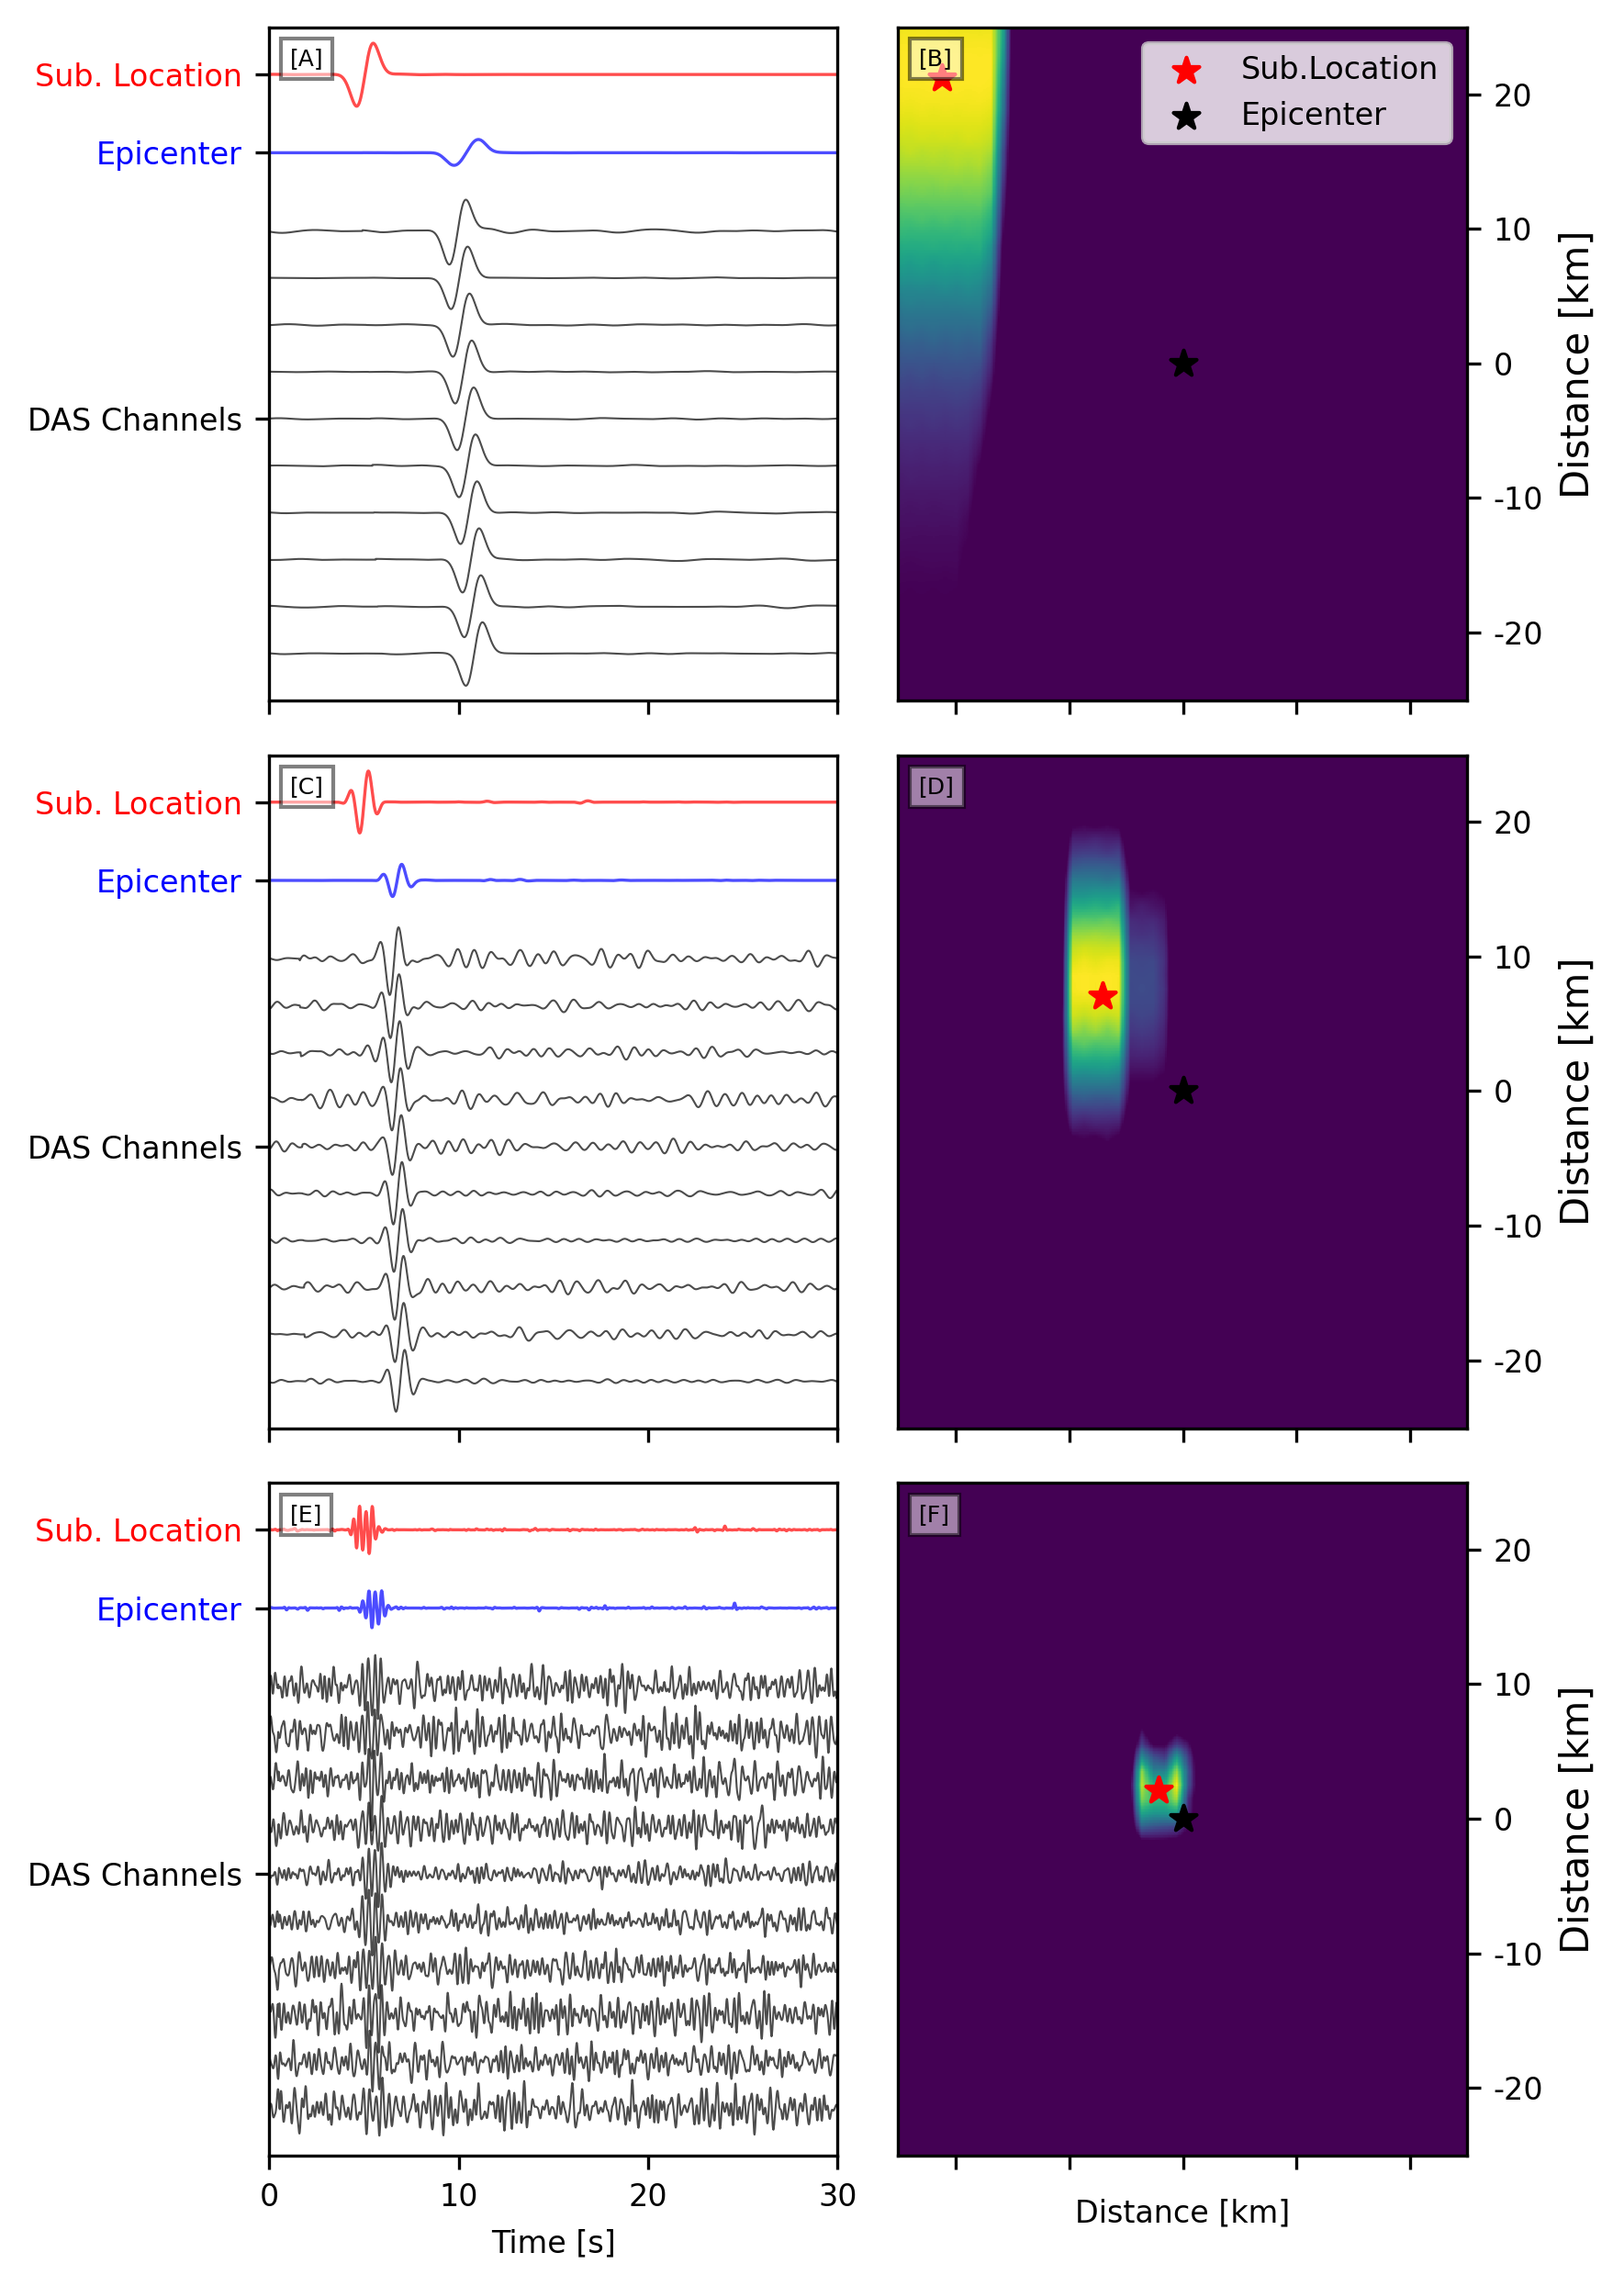

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6,8.4), dpi=300)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

labelcolors=['k','b','r']
axes = axes.flatten()

for c,ax in enumerate([axes[0],axes[2],axes[4]]):

    for i in range(10):
        ax.plot(t, seismograms_list[c][i]+i*1.5, alpha=0.7,c='k',lw=0.5)
        
    ax.plot(t, pwsed_bp_list[c][25,25]+16, alpha=0.7,c='b',lw=0.8)
    ax.plot(t, pwsed_bp_list[c][true_locations[c][0],true_locations[c][1]]+18.5, alpha=0.7,c='r',lw=0.8)
    
    ax.set_xlim(0,30)
    ax.set_ylim(-1.5,20)
    ax.set_xticks([0,10,20,30])
    ax.set_xticklabels(['','','',''])
    ax.set_yticks([7.5,16,18.5])
    ax.set_yticklabels(['DAS Channels','Epicenter','Sub. Location'],fontsize=8)
    
    for cc,label in enumerate(ax.get_yticklabels()):
        label.set_color(labelcolors[cc])
        

tt=[3,1,0.3]

for c,ax in enumerate([axes[1],axes[3],axes[5]]):
    
    stime=int((t0-tt[c]/2)*fs)
    etime=int((t0+tt[c]/2)*fs)
    
    master=np.max(pwsed_bp_list[c][:,:,stime:etime],axis=-1)
    resized_data=zoom(master,zoom=10,order=1)
    resized_data=normalize(resized_data)
    resized_x_mesh,resized_y_mesh=np.meshgrid(np.arange(-25,25,0.1),np.arange(-25,25,0.1))
    pc=ax.pcolormesh(resized_x_mesh,resized_y_mesh,resized_data.T,vmin=0.2)
    ax.scatter(-Ds[c]/2**0.5, Ds[c]/2**0.5,marker='*',c='r',s=50,label='Sub.Location')
    ax.scatter(0,0,marker='*',c='k',s=50,label='Epicenter')
    
    ax.set_xticks([-20,-10,0,10,20])
    ax.set_xticklabels(['','','','',''])
    ax.set_yticks([-20,-10,0,10,20])
    ax.set_yticklabels([-20,-10,0,10,20],fontsize=8)
    ax.set_ylabel('Distance [km]')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')

    
axes[4].set_xticks([0,10,20,30])
axes[4].set_xticklabels([0,10,20,30],fontsize=8)
axes[4].set_xlabel('Time [s]',fontsize=8)

axes[1].legend(fontsize=8)

axes[5].set_yticks([-20,-10,0,10,20])
axes[5].set_yticklabels([-20,-10,0,10,20],fontsize=8)
axes[5].set_xlabel('Distance [km]',fontsize=8)


texts=['[A]','[B]','[C]','[D]','[E]','[F]']
for c,ax in enumerate(axes):

    at = AnchoredText(texts[c],prop=dict(size=6), frameon=True,loc=2)
    at.patch.set_boxstyle('round',pad=0,rounding_size=0)
    at.patch.set_alpha(0.5)
    ax.add_artist(at)

plt.tight_layout()

In [11]:
master_mat1=np.load('data/das_bp_results/master_mat1.npy')
master_mat2=np.load('data/das_bp_results/master_mat2.npy')
master_mat3=np.load('data/das_bp_results/master_mat3.npy')

In [12]:
def cumulative_weighted_distance(matrix,threshold=0.8):

    max_val = np.max(matrix)
    normalized_matrix = matrix / max_val

    peak_index = np.unravel_index(np.argmax(normalized_matrix), normalized_matrix.shape)

    rows, cols = normalized_matrix.shape
    i_coords, j_coords = np.indices((rows, cols))
    
    distances = np.sqrt((i_coords - peak_index[0])**2 + (j_coords - peak_index[1])**2)
    
    mask = normalized_matrix > threshold
    
    weighted_distance = np.sum(normalized_matrix[mask] * distances[mask])
    
    return weighted_distance, peak_index, normalized_matrix

In [13]:
sig1=np.zeros((20,20))
sig2=np.zeros((20,20))
sig3=np.zeros((20,20))

for i in range(20):
    for j in range(20):
        sig1[i,j]=cumulative_weighted_distance(master_mat1[i,j])[0]
        sig2[i,j]=cumulative_weighted_distance(master_mat2[i,j])[0]
        sig3[i,j]=cumulative_weighted_distance(master_mat3[i,j])[0]

In [14]:
sig1=zoom(sig1,zoom=10,order=1)
sig2=zoom(sig2,zoom=10,order=1)
sig3=zoom(sig3,zoom=10,order=1)

resized_dist=np.linspace(300,800,200)
resized_azi=np.linspace(1,21,200)

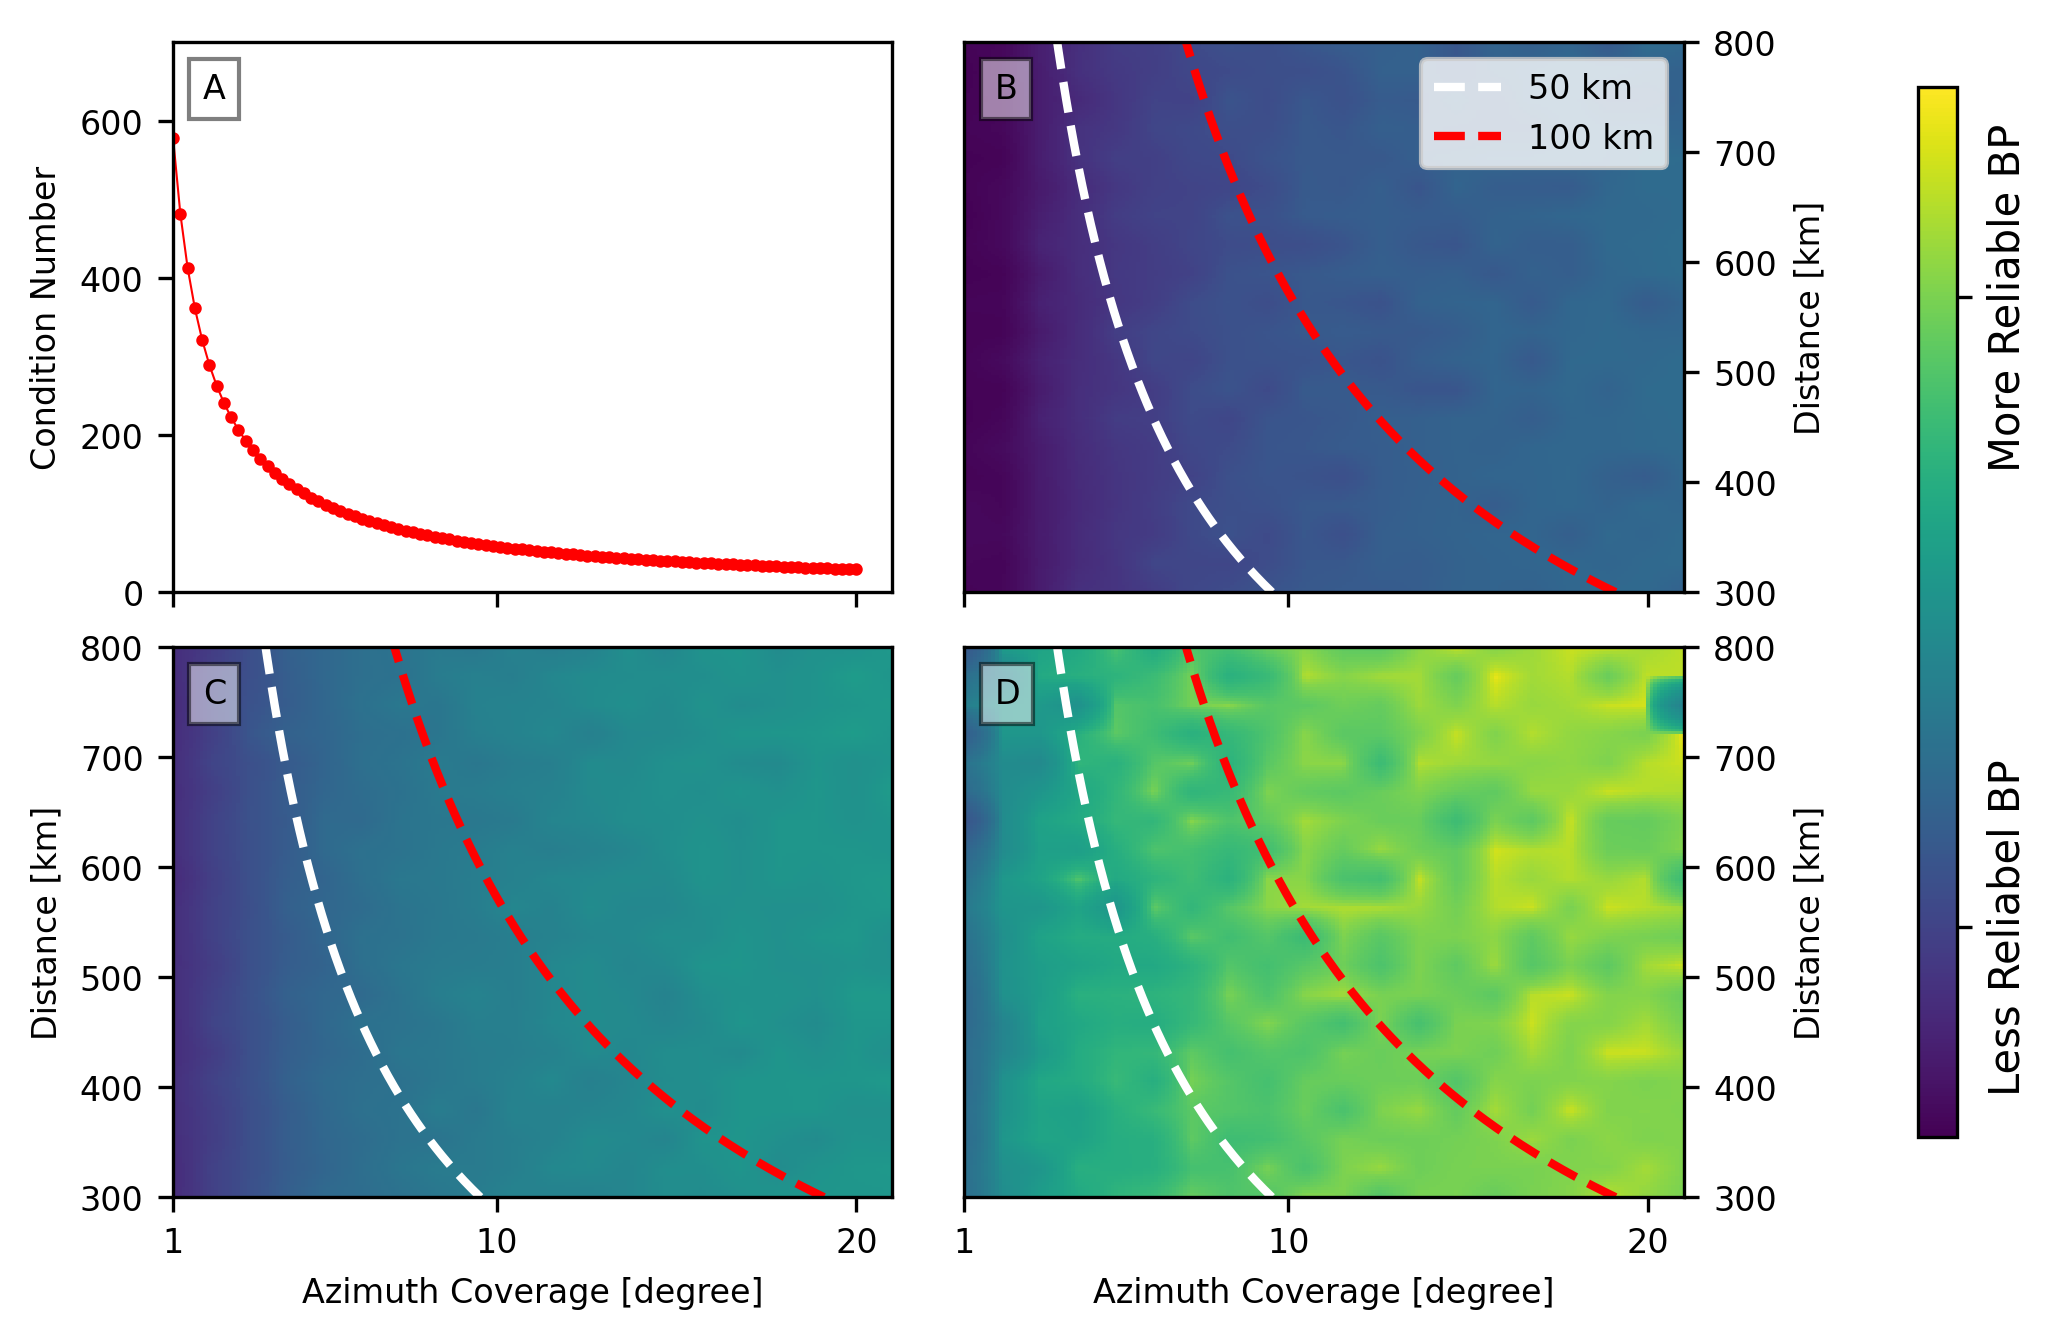

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6.5,5), dpi=300)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten()

for ax in axes:
    ax.set_xlim(1,21)
    ax.set_xticks([1,10,20])
    ax.set_xticklabels(['','',''])

axes[0].plot(coverage_angles_deg[1:], cond_numbers_coverage[1:], marker='o',markersize=2,lw=0.5,c='r')
axes[0].set_ylabel('Condition Number',fontsize=8)
axes[0].set_yticks([0,200,400,600])
axes[0].set_yticklabels([0,200,400,600],fontsize=8)  
axes[0].set_ylim(0,700)

pc=axes[1].pcolormesh(resized_azi,resized_dist,10-np.log(sig1),vmin=0,vmax=10)
axes[2].pcolormesh(resized_azi,resized_dist,10-np.log(sig2),vmin=0,vmax=10)
axes[3].pcolormesh(resized_azi,resized_dist,10-np.log(sig3),vmin=0,vmax=10)

axes[1].yaxis.set_ticks_position('right')
axes[1].yaxis.set_label_position('right')
axes[3].yaxis.set_ticks_position('right')
axes[3].yaxis.set_label_position('right')

for ax in axes[1:]:
    ax.set_ylim(300,800)
    ax.set_yticks([300,400,500,600,700,800])
    ax.set_yticklabels([300,400,500,600,700,800],fontsize=8)    
    ax.set_ylabel('Distance [km]',fontsize=8)
    
    line50 = (50.0 / resized_dist) * (180.0 / np.pi) 
    line100 = (100.0 / resized_dist) * (180.0 / np.pi)

    ax.plot(line50, resized_dist, color='white', linestyle='--', linewidth=2, label='50 km')
    ax.plot(line100, resized_dist, color='red', linestyle='--', linewidth=2, label='100 km')

axes[1].legend(fontsize=8)

for ax in axes[2:]:
    ax.set_xticks([1,10,20])
    ax.set_xticklabels([1,10,20],fontsize=8)
    ax.set_xlabel('Azimuth Coverage [degree]',fontsize=8)

cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
cbar=fig.colorbar(pc, cax=cbar_ax)
cbar.ax.set_yticks([2,8])
cbar.ax.set_yticklabels(["Less Reliabel BP", "More Reliable BP"])
plt.setp(cbar.ax.get_yticklabels(), rotation=90,va='center')

texts=['A','B','C','D']
for c,ax in enumerate(axes):
    at = AnchoredText(texts[c],prop=dict(size=8), frameon=True,loc=2)
    at.patch.set_boxstyle('round',pad=0,rounding_size=0)
    at.patch.set_alpha(0.5)
    ax.add_artist(at)

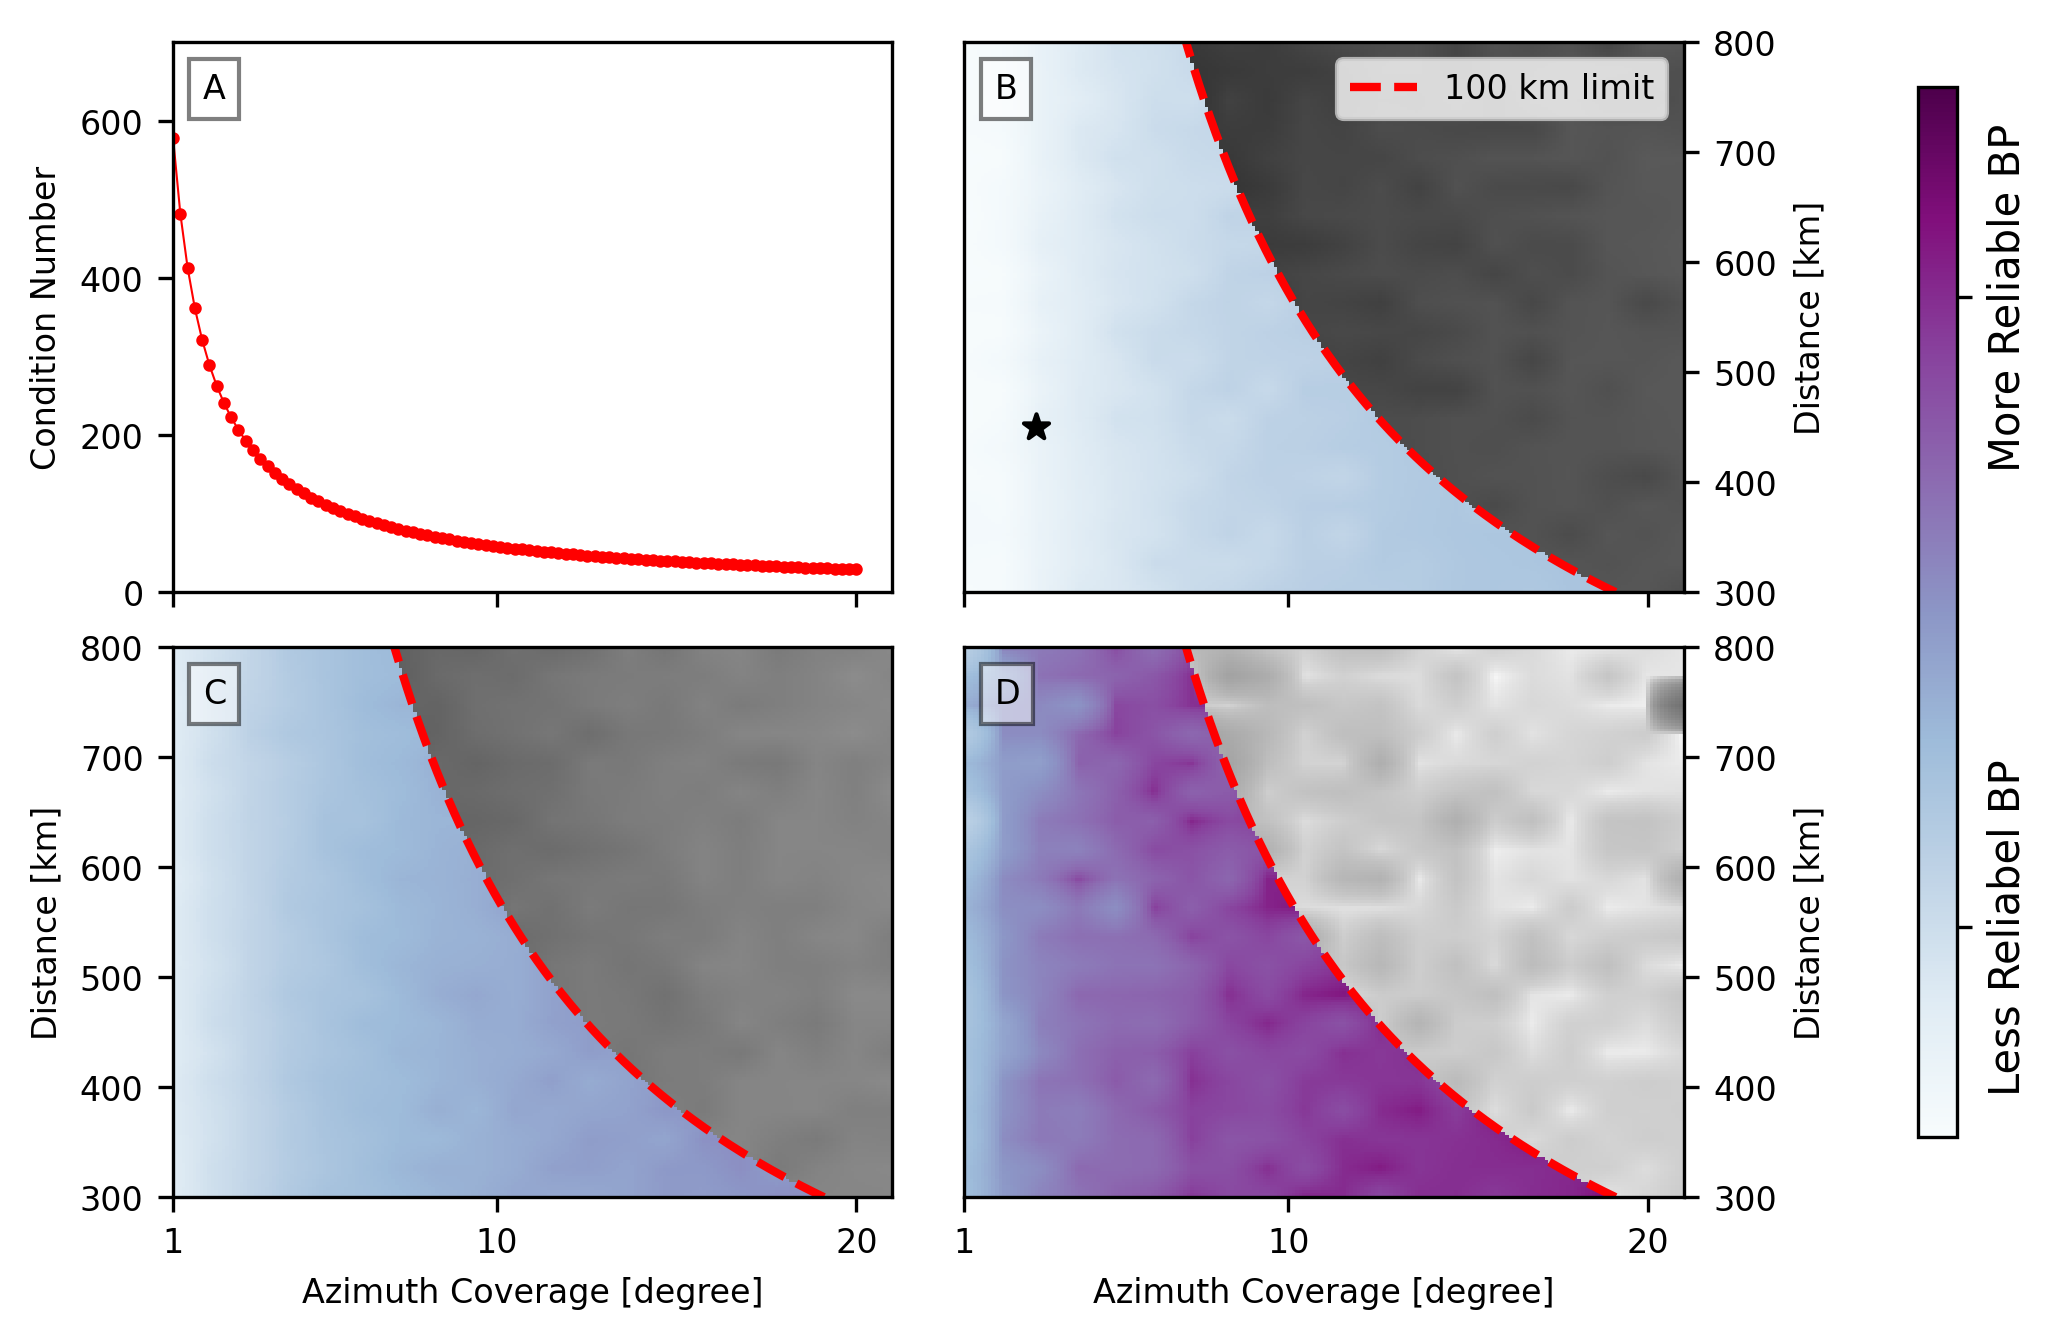

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6.5,5), dpi=300)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten()
X,Y=np.meshgrid(resized_azi,resized_dist)

for ax in axes:
    ax.set_xlim(1,21)
    ax.set_xticks([1,10,20])
    ax.set_xticklabels(['','',''])

axes[0].plot(coverage_angles_deg[1:], cond_numbers_coverage[1:], marker='o',markersize=2,lw=0.5,c='r')
axes[0].set_ylabel('Condition Number',fontsize=8)
axes[0].set_yticks([0,200,400,600])
axes[0].set_yticklabels([0,200,400,600],fontsize=8)  
axes[0].set_ylim(0,700)

line100 = (100.0 /resized_dist) * (180.0 / np.pi)
ref= (100.0 /Y) * (180.0 / np.pi)
mask_left = X <= ref
mask_right = X > ref
Z_left1 = np.ma.masked_where(~mask_left, 10-np.log(sig1))
Z_right1 = np.ma.masked_where(~mask_right, 10-np.log(sig1))
Z_left2 = np.ma.masked_where(~mask_left, 10-np.log(sig2))
Z_right2 = np.ma.masked_where(~mask_right, 10-np.log(sig2))
Z_left3 = np.ma.masked_where(~mask_left, 10-np.log(sig3))
Z_right3 = np.ma.masked_where(~mask_right, 10-np.log(sig3))

pc=axes[1].pcolormesh(X,Y,Z_left1,vmin=0,vmax=10,shading='auto',cmap='BuPu')
axes[1].pcolormesh(X,Y,Z_right1,vmin=0,vmax=10,shading='auto',cmap='grey')
axes[2].pcolormesh(X,Y,Z_left2,vmin=0,vmax=10,cmap='BuPu')
axes[2].pcolormesh(X,Y,Z_right2,vmin=0,vmax=10,shading='auto',cmap='grey')
axes[3].pcolormesh(X,Y,Z_left3,vmin=0,vmax=10,cmap='BuPu')
axes[3].pcolormesh(X,Y,Z_right3,vmin=0,vmax=10,shading='auto',cmap='grey')

axes[1].scatter(3,450,s=40,marker='*',c='k')

axes[1].yaxis.set_ticks_position('right')
axes[1].yaxis.set_label_position('right')
axes[3].yaxis.set_ticks_position('right')
axes[3].yaxis.set_label_position('right')

for ax in axes[1:]:
    ax.set_ylim(300,800)
    ax.set_yticks([300,400,500,600,700,800])
    ax.set_yticklabels([300,400,500,600,700,800],fontsize=8)    
    ax.set_ylabel('Distance [km]',fontsize=8)

    ax.plot(line100, resized_dist, color='red', linestyle='--', linewidth=2, label='100 km limit')

axes[1].legend(fontsize=8)

for ax in axes[2:]:
    ax.set_xticks([1,10,20])
    ax.set_xticklabels([1,10,20],fontsize=8)
    ax.set_xlabel('Azimuth Coverage [degree]',fontsize=8)

cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
cbar=fig.colorbar(pc, cax=cbar_ax)
cbar.ax.set_yticks([2,8])
cbar.ax.set_yticklabels(["Less Reliabel BP", "More Reliable BP"])
plt.setp(cbar.ax.get_yticklabels(), rotation=90,va='center')

texts=['A','B','C','D']
for c,ax in enumerate(axes):
    at = AnchoredText(texts[c],prop=dict(size=8), frameon=True,loc=2)
    at.patch.set_boxstyle('round',pad=0,rounding_size=0)
    at.patch.set_alpha(0.5)
    ax.add_artist(at)